# Workshop on Models of an Epidemic

by Kaylee Vo

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Problem 1: SIR Model
- *Continuous deterministic model*

### Part A

**Use ode45 in Matlab (or a similar function in Python) to solve this system.**

The SIR model can be expressed as a system of ODEs:

$$
\frac{dS}{dt} = - \frac{a}{N} I S
$$

$$
\frac{dI}{dt} = \frac{a}{N} I S - b I
$$

$$
\frac{dR}{dt} = b I
$$

, where $N = S(t) + I(t) + R(t)$. The model assumes the the population has no births or deaths. Other assumptions include
- Parameters $a$ and $b$ are constant over time. This means that the transmission rate and recovery rate do not change.
    - $a = pt \cdot nc$, where $pt$ is the probability of transmission per contact, $n$ is the number of contacts per person per day.
- There is homogeneous mixing of the population.
- There is perfect immunity after recovery.
- There are no other states other than susceptible, infected, and recovered.
- The only edges are $S \to I$ and $I \to R$, which can be interpreted as no mutation or reinfection.

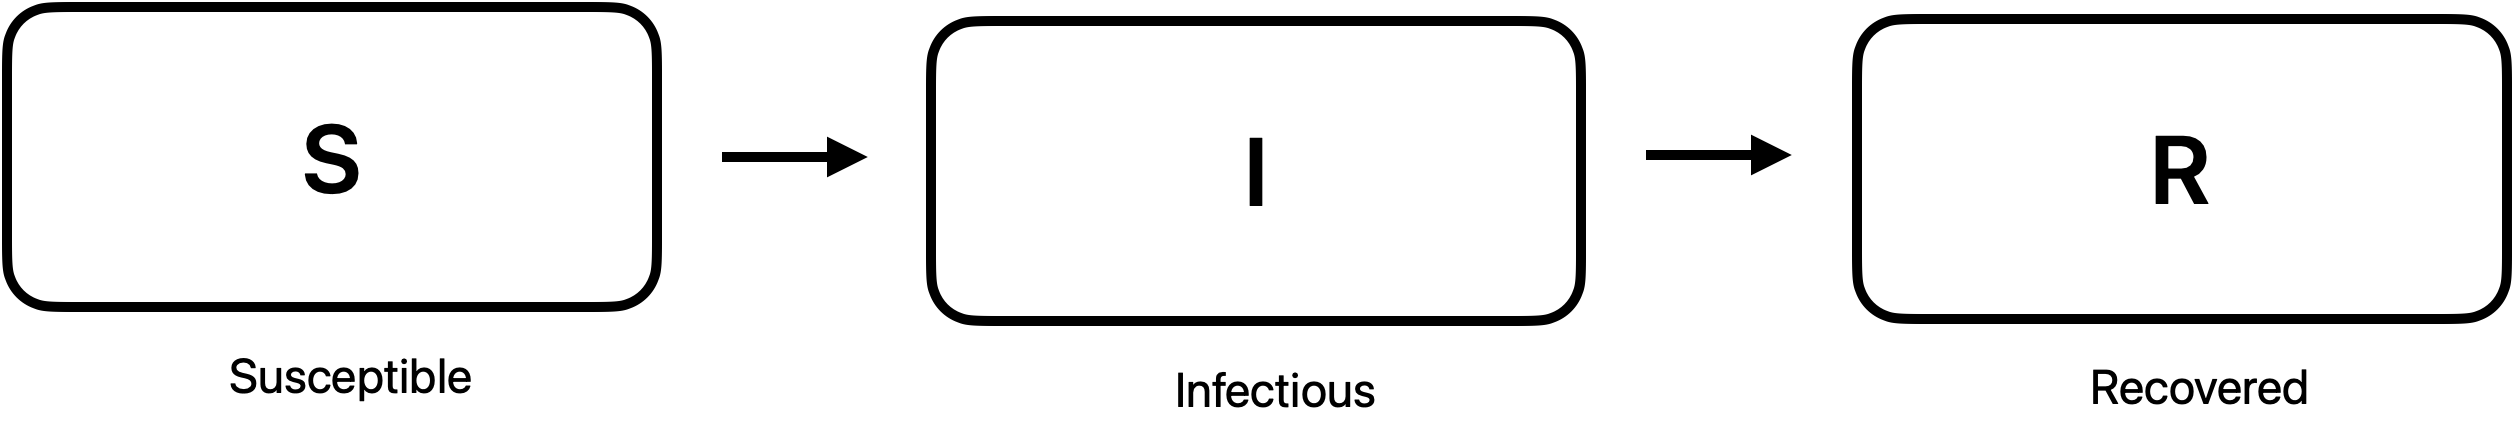

In [6]:
from IPython.display import Image

Image("./SIR_dag.png", width=500, height=500)

In [7]:
def sir(t, X, a, b, N):

    s = X[0]
    i = X[1]
    r = X[2]

    ds = -a * s * i / N
    di = a * i * s / N - b * i
    dr = b * i

    return [ds, di, dr]

In [8]:
# Set parameters according to the problem specs
tspan = [0.0, 20]
t_eval = np.arange(0, 20, 0.1)
a = 2 * np.log(2)
b = np.log(2)
N = 1000

# S, I, R
X0 = [999, 1, 0]

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol = solve_ivp(sir, tspan, X0, args=(a, b, N), method="Radau", t_eval=t_eval)
# Unpack solution
T, X = sol.t, sol.y

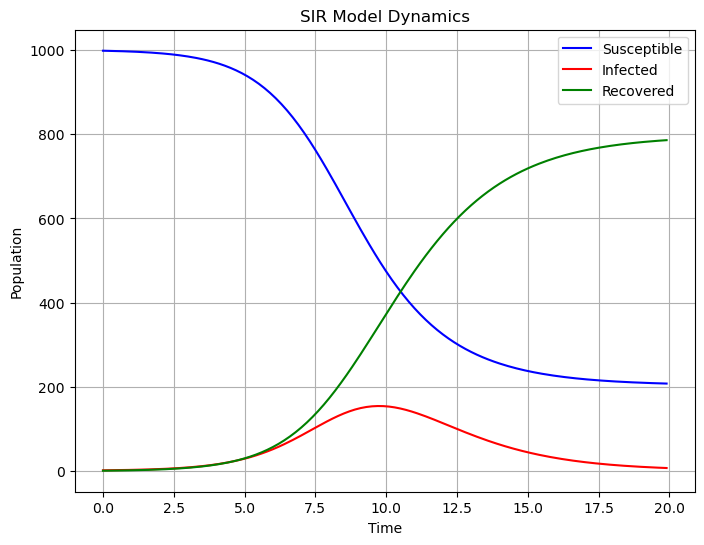

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T, X[0], label="Susceptible", color="blue")
ax.plot(T, X[1], label="Infected", color="red")
ax.plot(T, X[2], label="Recovered", color="green")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("SIR Model Dynamics")
ax.legend()
ax.grid()
plt.show()

#### Part B

**i. what do you expect the initial growth of the infected to be like (linear, 
quadratic, or exponential)?**

We have the equation for the change in infected individuals:

$$
\frac{dI}{dt} = \frac{a}{N} I S - b I.
$$

At the beginning of the epidemic $S \approx N$. We can rewrite the above as:

$$
\frac{dI}{dt} = aI - bI = I(a - b) = cI
$$

This shows that the intital growth of the infected will be exponential, because the solution to this equation was shown to be exponential in the first lecture:

$$
I(t) = I(0) e^{c t}.
$$

**ii. And at what population of the Susceptible do you expect the 
number of the Infected to decrease?**

To find when the population of Susceptible when the number of Infected will decrease, we can set $\frac{dI}{dt} = 0$. This gives us:

$$
\frac{a}{N} I S - b I = 0.
$$

$$
\frac{a}{N} S = b. \rightarrow S = \frac{bN}{a}.
$$

From the above, we can say that the proportion of Susceptible individuals at which the number of Infected individuals will start to decrease is when

$$
\frac{S}{N} < \frac{b}{a}.
$$

When the proportion of Susceptible individuals is less than the inverse of the $R_0$ value, the number of Infected individuals will start to decrease.


**Remark**:

To confirm critical point found above is a maximum, we'll take the second derivative:

$$
\frac{d^2I}{dt^2} = I' (\frac{a}{N} S - b) + I \frac{a}{N} S'.
$$

Evaluate it at the critical point:

$$
\frac{d^2I}{dt^2} = I \frac{a}{N} S'
$$

Plug in $S' = - \frac{a}{N} IS$:

$$
\frac{d^2I}{dt^2} = - \frac{a^2}{N}I^2S
$$

We know the second derivative is negative because $a, N, I, S$ are all positive. Therefore, the critical point is a maximum.

In [10]:
# S when I is at its maximum
b * N / a

499.99999999999994

- For this case, at a susceptible population of 500, the number of infected will decrease.
- The herd immunity threshold.

#### Part C

**Hold the value of b the same, change a to produce  different R0 values to explore its effect**

In [11]:
# Set parameters according to the problem specs
tspan = [0.0, 20]
t_eval = np.arange(0, 20, 0.1)
a = 3 * np.log(2)
b = np.log(2)
N = 1000

# S, I, R
X0 = [999, 1, 0]

# Solve ODE with 'Radau' or 'BDF' for stiff problems
sol = solve_ivp(sir, tspan, X0, args=(a, b, N), method="Radau", t_eval=t_eval)
# Unpack solution
T, X = sol.t, sol.y

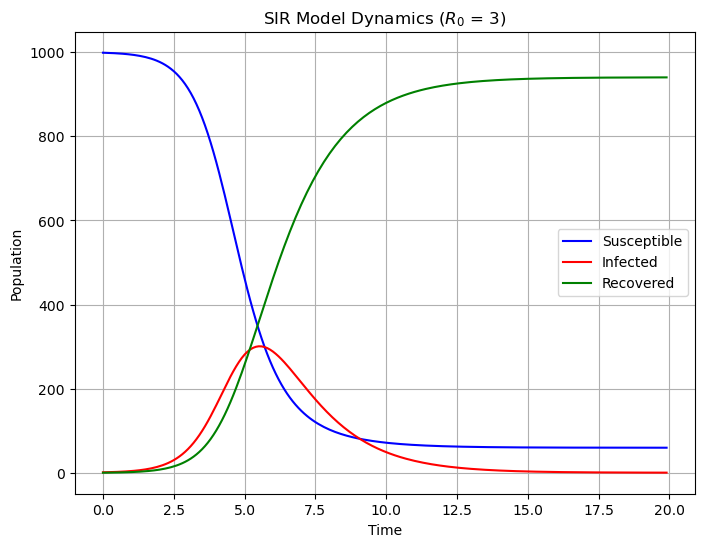

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T, X[0], label="Susceptible", color="blue")
ax.plot(T, X[1], label="Infected", color="red")
ax.plot(T, X[2], label="Recovered", color="green")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("SIR Model Dynamics ($R_0$ = 3)")
ax.legend()
ax.grid()
plt.show()

In [13]:
# S when I is at its maximum
b * N / a

333.3333333333333

- With a larger $R_0$, the growth of the infected population is faster, and the peak of the infected population is higher.

## Problem 2: Reed-Frost model
- *Stochastic probabilistic model*

In [14]:
np.random.seed(115)  # For reproducibility

nsteps = 20000
dt = 1e-3

# Keep same parameters
a = 2 * np.log(2)  # infection rate
b = np.log(2)  # recovery rate
N = 1000  # total population

Ss = np.zeros(nsteps)
Is = np.zeros(nsteps)
Rs = np.zeros(nsteps)

# Initial conditions
Ss[0] = N - 1
Is[0] = 1
Rs[0] = 0
total_infected = 1

for t in range(nsteps - 1):
    r = np.random.rand()

    # Infection rate
    p_infect = a * Ss[t] * Is[t] / N * dt
    # Recovery rate
    p_recover = b * Is[t] * dt

    # infection case
    if r < p_infect:
        Ss[t + 1] = Ss[t] - 1
        Is[t + 1] = Is[t] + 1
        Rs[t + 1] = Rs[t]
        total_infected += 1
    # recovery case
    # we add to ensure the random number is within the correct bin
    elif r < p_infect + p_recover:
        Ss[t + 1] = Ss[t]
        Is[t + 1] = Is[t] - 1
        Rs[t + 1] = Rs[t] + 1
    # no change
    else:
        Ss[t + 1] = Ss[t]
        Is[t + 1] = Is[t]
        Rs[t + 1] = Rs[t]

In [15]:
total_infected

760

- We assume the conditional probability of the populations of Susceptible and Infected at time $t+h$ given their  populations at time $t$ for a time interval $h$ small enough that only one infection or recovery event can happen.
- That is why we have separate if-else clauses.

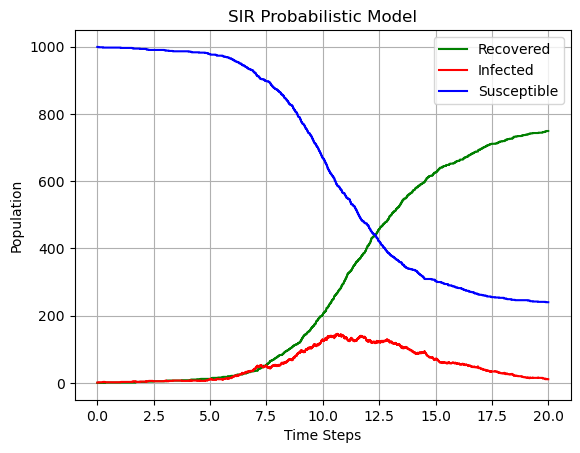

In [16]:
# Divide by 1000
# To make consistent with the deterministic, continuous model
time = np.arange(nsteps) / 1000

plt.plot(time, Rs, label="Recovered", color="green")
plt.plot(time, Is, label="Infected", color="red")
plt.plot(time, Ss, label="Susceptible", color="blue")
plt.xlabel("Time Steps")
plt.ylabel("Population")
plt.title("SIR Probabilistic Model")
plt.legend()
plt.grid()
plt.show()

## Problem 3

**Check consistency between the deterministic and the probabilistic approaches.**

The approaches are consistent.
- the peak for the infected population occurs when S = 500 in both cases.
- The height of the infected peak is just shy of 200 in both cases.
- Recovered levels off around 800 in both cases.
- Susceptible levels off around 200 in both cases.

## Problem 4

**We can also model the spread of infectious diseases by representing each individual in the population explicitly. A separate discussion of the individual agent model is on the course webpage, along with the codes. Use them to model the epidemic as well.**

For this section, we'll simply run the code provided model_epidemic_1d.ipynb. The notebook models the epidemic using an individual-agent model.

In [17]:
# Code borrowed from model_epidemic_1d.ipynb
def simulate1D(n, nc, pt):
    """Package the simulation steps of intializng the population
    vector and iterating the epidemic and census functions unit I=0
    the censuses are accumulated in a results matrix

    Args:
        n (int): time
        nc (numpy.ndarray): population
        pt (float): parameter value

    Returns:
        tt (list): time
        results (list): sir subpopulation at each time

    """

    t = 0
    # Set up an intial population of susceptibles
    pop = initial1D(n, 0, 0)
    # Put an infected individual in the middle
    pop[int(n / 2) - 1] = "i"
    s, i, r = census1D(pop)
    # Start the results mnatrix
    results = [[s, i, r]]
    tt = [t]

    while i > 0:
        pop = epidemic1D(nc, pt, pop)
        s, i, r = census1D(pop)
        results.append([s, i, r])
        t = t + 1
        tt.append(t)

    return tt, results

In [18]:
def initial1D(s0, i0, r0):
    """Set an initial population vector for the epidemic simulation;
    each state subpopulation is appended to the growing vector, pop

    NOTE: if position in the array is important,eg. if you are modeling
    local neighborhood contacts, each individual must be placed
    randomly in the array

    Args:
        s0 (int): initial population of susceptibles
        i0 (int): initial population of infectious
        r0 (int): initial population of recovered

    Returns:
        list: net population vector of subpopulation of each state

    """

    pop = []
    for i in range(s0):
        pop.append("s")
    for i in range(i0):
        pop.append("i")
    for i in range(r0):
        pop.append("r")

    return pop

In [19]:
def census1D(pop):
    """Count the number of s, i and r cells in pop

    Args:
        pop (list): net population vector of subpopulation of each state

    Returns:
        s (int): number of susceptibles
        i (int): number of infectious
        r (int): number of recovered

    """

    s = 0
    i = 0
    r = 0
    # pop is a 1 by n array
    n = np.array(pop).shape[0]

    for j in range(n):
        if pop[j] == "s":
            s += 1
        elif pop[j] == "i":
            i += 1
        elif pop[j] == "r":
            r += 1

    return s, i, r

In [20]:
np.random.seed(115)


def epidemic1D(nc, pt, pop1):
    """Calculate a new pop2 vector of 's', 'i', and 'r' from
    the current pop1 assuming that all 'i' cells go to 'r'
    after each has nc random infectious contacts with other
    cells. An 's' cell goes to 'i' with probability, pt, if
    it is contacted by an 'i'

    Args:
        nc (int): all 'i' cells go to 'r' after random
                  infectious contacts with other cells
        pt (float): probability of 's' cell going to 'i'
        pop1 (list): current net population vector

    Returns:
        list: new net population vector

    """

    pop2 = pop1.copy()  # Set up new vector
    n = np.array(pop1).shape[0]
    for j in range(n):
        if pop1[j] == "i":
            for c in range(nc):  # nc contact
                k = j
                while k == j:  # try to generate a random k NOT equal to j
                    k = np.random.randint(n)  # random individual to contact
                if (
                    pop1[k] == "s" and np.random.rand() < pt
                ):  # rand<pt generates a Bernoulli trial
                    pop2[k] = "i"  # infect the 's' cell
            # after one unit of time the individual recovers
            pop2[j] = "r"  # then the jth individual recovers

    return pop2

Before running code, let's make sure parameters are the same as in prior sections. We know $a = pt \cdot nc$, where $pt$ is the probability of transmission per contact and $nc$ is the number of contacts per person per unit time. We can then set $pt = 0.5$ and $nc = 4$ to get $a = 2$. The code implicitly sets $b=1$ because in the for-loop, we assume that the infected individuals recover after one time step. Lastly, we set the population size to 1000.



In [21]:
# Use 999 because we set one infect individual
# in the middle of the population
# n, nc, pt
tt, results = simulate1D(999, 4, 0.5)
results = np.array(results)  # change results to numpy.ndarray for plotting purposes

In [22]:
# Customize for matplotlib
# If interested in the matplotlib object hierarchy, check: https://realpython.com/python-matplotlib-guide/
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["mathtext.default"] = "regular"
# Change font size: http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["figure.titlesize"] = 20

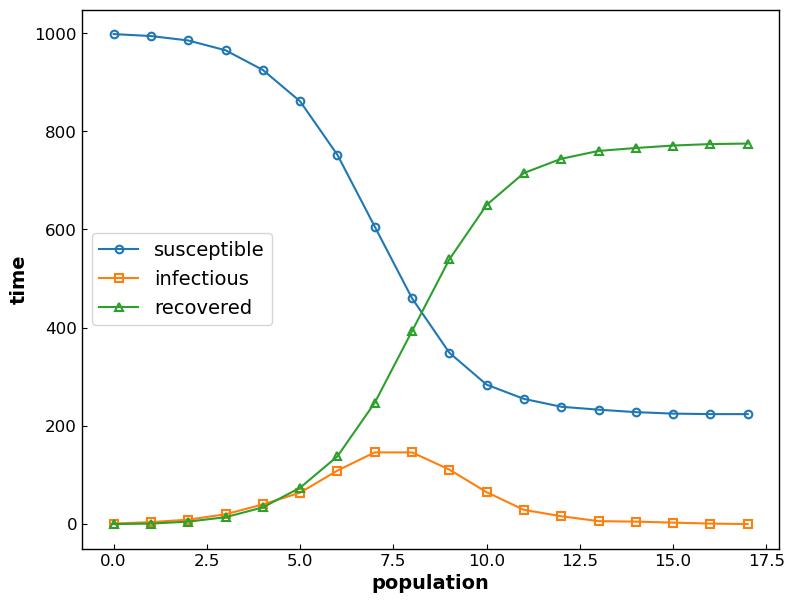

In [23]:
# Plot solution
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

ax.plot(
    tt,
    results[:, 0],
    "-o",
    linewidth=1.5,
    mfc="none",
    ms=5.5,
    mew=1.5,
    label="susceptible",
)
ax.plot(
    tt,
    results[:, 1],
    "-s",
    linewidth=1.5,
    mfc="none",
    ms=5.5,
    mew=1.5,
    label="infectious",
)
ax.plot(
    tt,
    results[:, 2],
    "-^",
    linewidth=1.5,
    mfc="none",
    ms=5.5,
    mew=1.5,
    label="recovered",
)

# Set axes labels and legends
ax.set_xlabel("population")
ax.set_ylabel("time")
ax.legend(loc="center left")

plt.show()

With the same parameters as the SIR and Reed-Frost models, we can see that the individual-agent model matches the results from prior sections. The peak of the infected occurs when the susceptible population is around 500, and the peak of the infected population is just shy of 200. The recovered population levels off around 800, and the susceptible population levels off around 200.

## Problem 5

**Discuss the pros and cons of the different approaches.**

**SIR Model**

Pros
- Works well for large N because the law of large number kicks in, washing out variations in subpopulations
- Continuous-deterministic makes the the math tractable, allowing for formal analysis, ease of computation, and flexibility for future adjustments (e.g. add vaccination or birth/deaths).
- Captures the key dynamics of an epidemic (herd immunity, peak infection, growth and slowdown of epidemic)

Cons
- Aggregate in nature: no demographics, assumes individuals are the same
- Assumes homogeneous mixing
- Parameters are time-invariant
- Perfect immunity after recovery
- System can be described with three variable (S, I, and R)
- No latency, individuals transition immediately from S to I.

**Reed-Frost Model**

Pros
- Stochasticity arguably is more realistic since infection and recovery are probabilitistic
- Good for small N because the model captures the randomness in transmission
- Simple to simulate

Cons
- Assumes homogeneous mixing. This means individuals move about a space randomly which isn't necessarily true since humans tend to congregate in specific areas/groups.
- Parameters are time-invariant
- Time is discrete
- Assumes individuals recover after one time-step
- Assumes each contact with an infected person is an independent event


**Individual-Agent Model**

Pros
- Captures individual hetereogeneity. Individuals can be represented by a single variable, for example the state descriptor of the specific individual as to being susceptible, infected or recovered, or a complex data structure of descriptors, such as age, sex, height, weight.
- can model spatial components (e.g. cities, neighborhoods) and temporal components (can be continuous or discrete).
- Can track individual-level outcomes (e.g. vaccination and quarantine).


Cons
- Complex dynamic functions usually prohibit any formal analysis. Running the simulation program with specific parameter values is pretty much all you can do with it.
- Computationally intensive, reproducibility issues and often many parameters.



## Problem 6

**Make a list of the different ways that mathematical modeling was used in the fight against the COVID-19 pandemic.**

1. Forecasting of the epidemic incidence rate, hospitalization rate and mortality rate. Allowing for the allocation of resources and planning of healthcare systems.
2. Estimate of the reproduction number $R_0$ to help gauge the severity of the epidemic.
3. Estimation of key thresholds such as the $N$ that is required for herd immunity.
4. Finding the optimal vaccination and testing strategies to minimize the spread of the disease and maximize the number of people who are protected.
5. Evaluation of the effectiveness of interventions such as social distancing, mask mandates, and lockdowns on the spread of the virus.


Source
1. https://pmc.ncbi.nlm.nih.gov/articles/PMC7523122/